<a href="https://colab.research.google.com/github/Ekta-kature/FMMLprojectsandlab/blob/main/MODULE_7_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2024-03-12 10:00:19--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.69MB/s    in 0.3s    

2024-03-12 10:00:21 (3.69 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


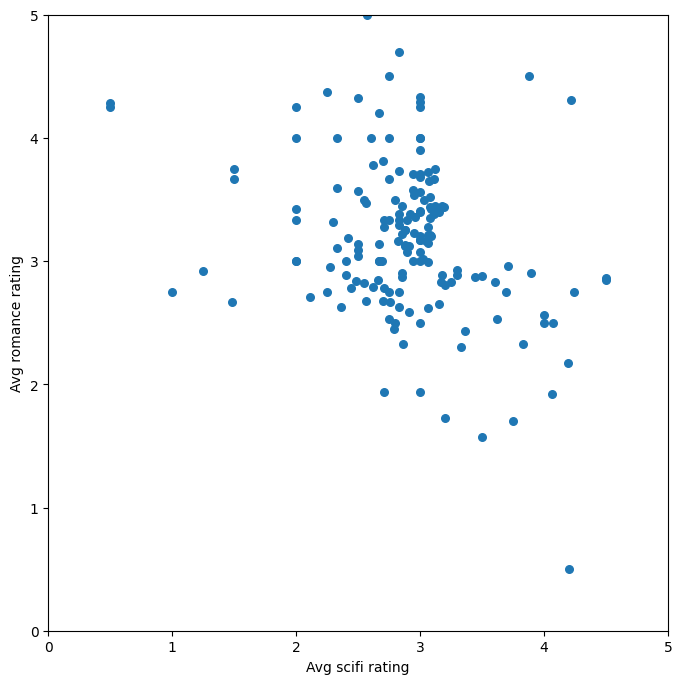

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


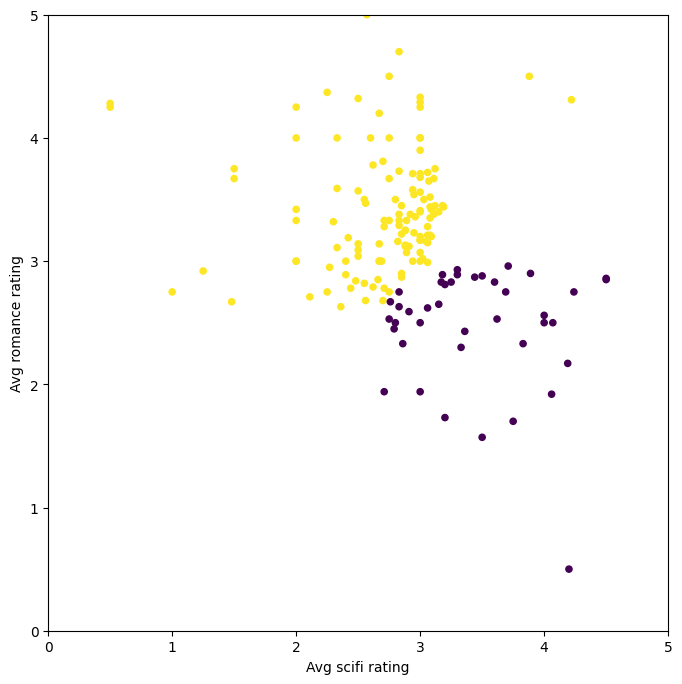

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


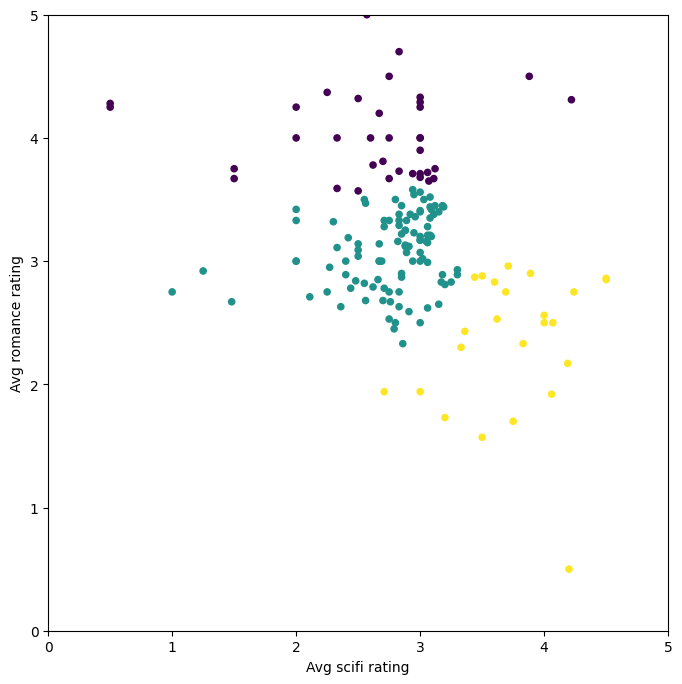

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

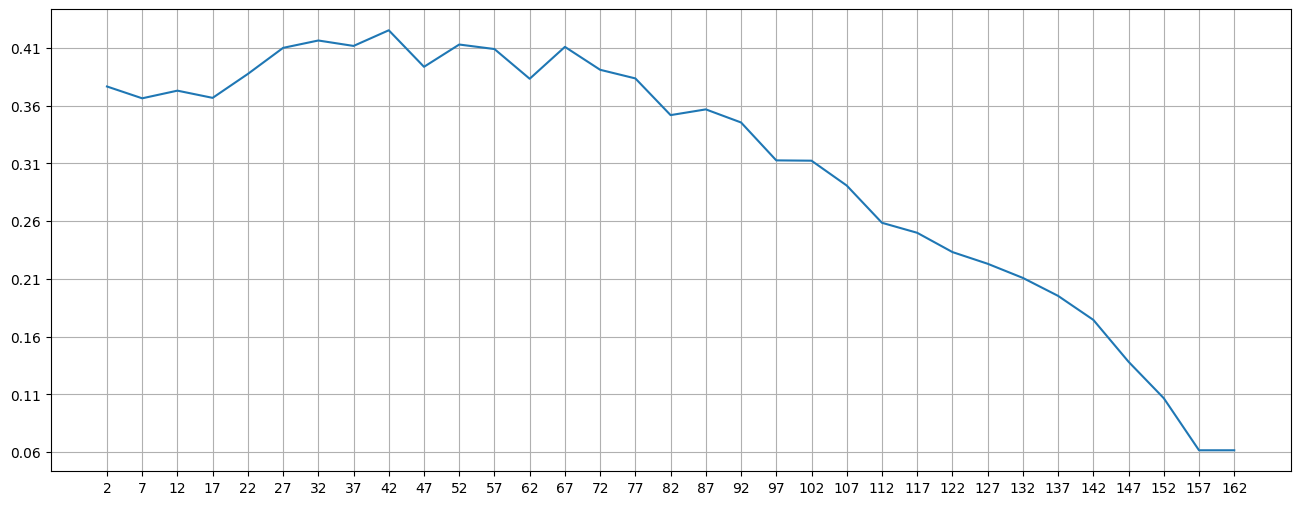

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


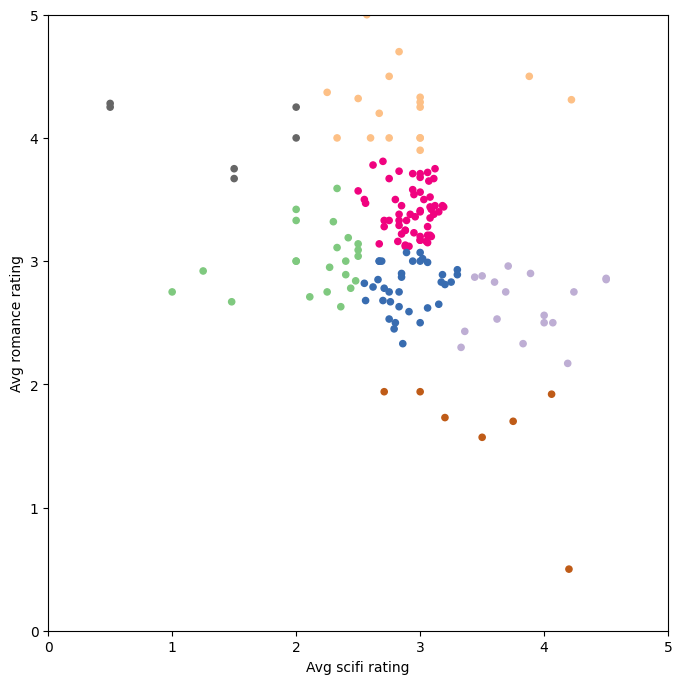

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


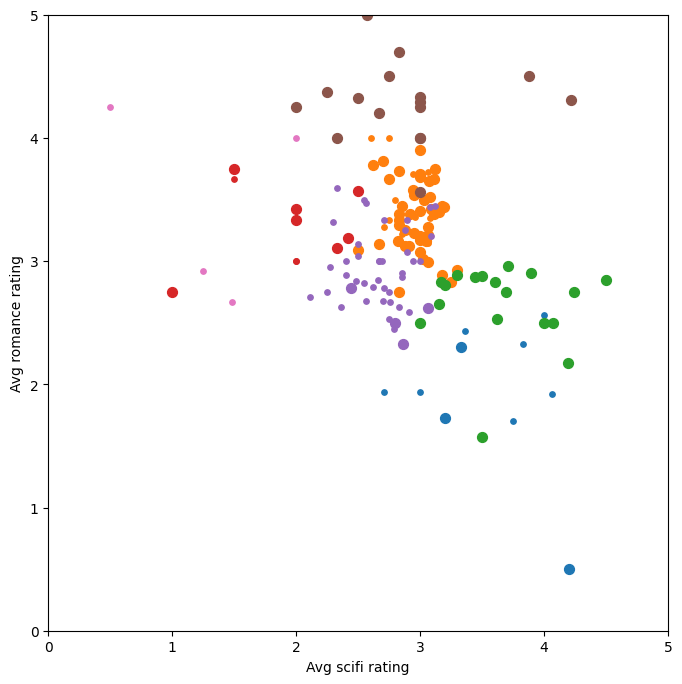

In [14]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

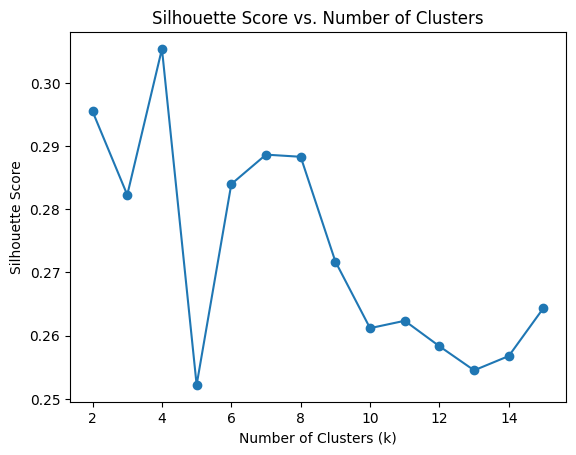

Optimal number of clusters: 4


In [15]:
from sklearn.metrics import silhouette_score

# Define a range of k values to test
possible_k_values = range(2, 16)

# Calculate silhouette scores for each value of k
silhouette_scores = []
for k in possible_k_values:
    kmeans = KMeans(n_clusters=k)
    predictions = kmeans.fit_predict(X_with_action)
    silhouette_avg = silhouette_score(X_with_action, predictions)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores against the number of clusters
plt.plot(possible_k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

# Find the optimal number of clusters (k) with the highest silhouette score
optimal_k = possible_k_values[np.argmax(silhouette_scores)]
print("Optimal number of clusters:", optimal_k)


### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [16]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

# Define function to get the user who rate a movie the most
def get_users_who_rate_the_most(most_rated_movies, n_users):
    most_rated_movies['num_ratings'] = - most_rated_movies.isnull().sum(axis=1)
    most_rated_movies = most_rated_movies.sort_values(by=['num_ratings'], ascending=False)
    most_rated_movies = most_rated_movies.iloc[:n_users, :]
    most_rated_movies = most_rated_movies.drop('num_ratings', axis=1)
    return most_rated_movies

# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
# print(most_rated_movies_users_selection)
print('dataset dimensions: ', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())

<ipython-input-17-0b2c7ceec495>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


dataset dimensions:  (18, 30)
title  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
413                    5.0                               5.0   
589                    5.0                               4.5   
473                    3.0                               5.0   
479                    5.0                               5.0   
67                     3.5                               3.0   

title  Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
413                    5.0                               4.0   
589                    4.5                               3.5   
473                    4.0                               4.5   
479                    4.0                               4.5   
67                     2.0                               3.5   

title  Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
413                   5.0                                        5.0   
589                   4.0                               

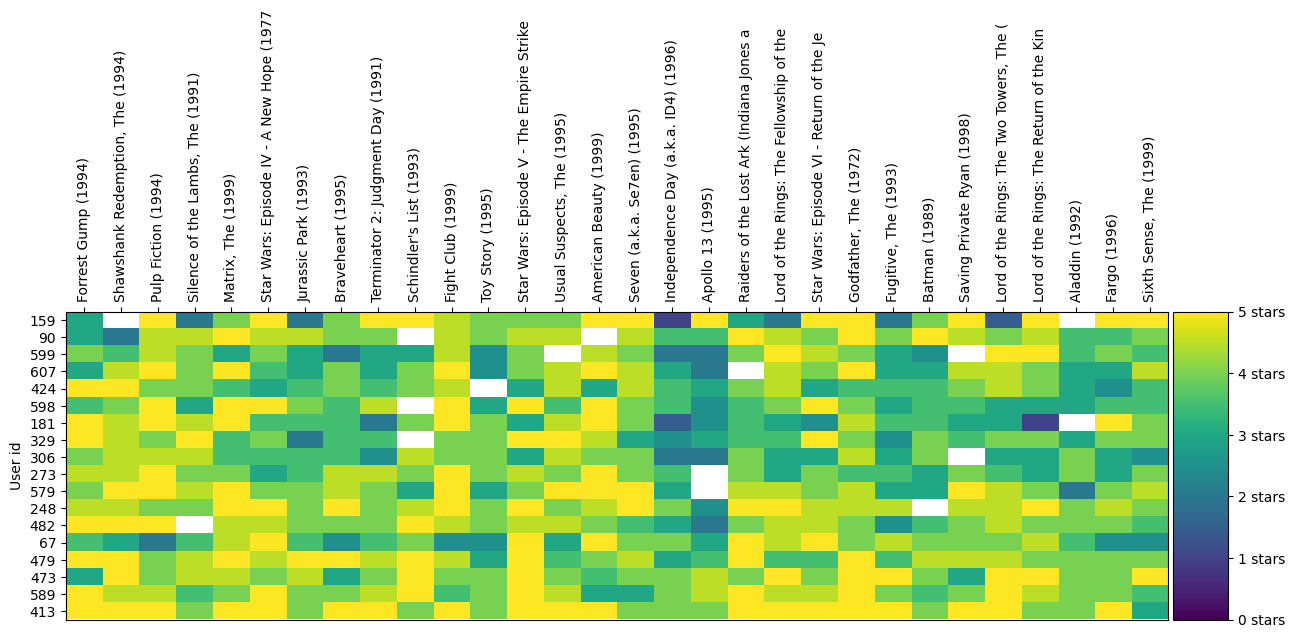

In [18]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [19]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

<ipython-input-17-0b2c7ceec495>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


In [20]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

In [21]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)
# Select the mas number of users and movies heatmap cluster
# Cluster and print some of them
clustered = pd.concat([get_most_rated_movies(user_movie_ratings, 1000).reset_index(), pd.DataFrame({'group':predictions})], axis=1)
# draw_movie_clusters(clustered, max_users, max_movies)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
<ipython-input-17-0b2c7ceec495>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


### Predictions and Recommendation

     Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
4                    NaN                               3.0   
7                    3.0                               5.0   
10                   5.0                               4.0   
13                   4.0                               3.0   
25                   3.0                               NaN   
34                   NaN                               NaN   
36                   4.0                               4.0   
45                   NaN                               4.0   
53                   4.0                               4.0   
55                   5.0                               4.0   
80                   2.0                               3.0   
92                   5.0                               4.0   
93                   3.0                               5.0   
98                   NaN                               5.0   
101                  5.0                               4.0   
106     

<ipython-input-17-0b2c7ceec495>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


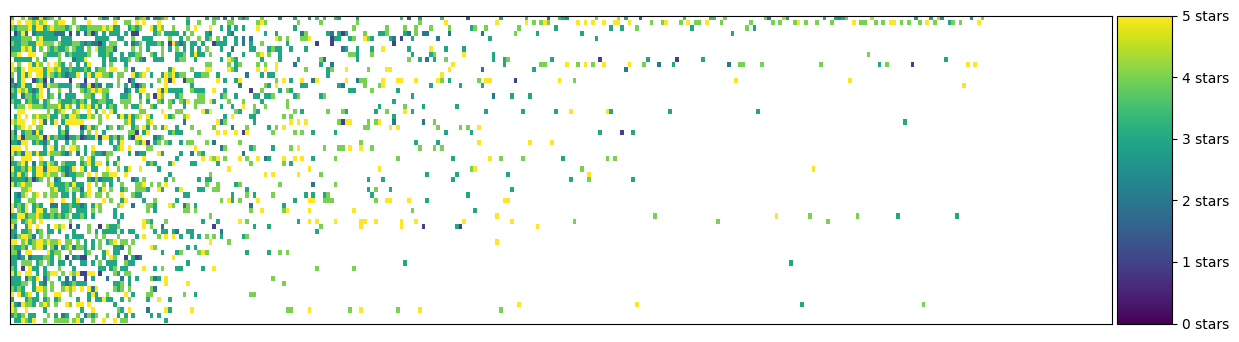

In [22]:
# Pick a cluster ID from the clusters above
cluster_number = 11
# Let's filter to only see the region of the dataset with the most number of values
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
print(cluster)
# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [23]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

3.0

In [24]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Apollo 13 (1995)                          3.948980
Batman (1989)                             3.104167
True Lies (1994)                          3.652174
Pulp Fiction (1994)                       3.913043
Dances with Wolves (1990)                 3.955556
Forrest Gump (1994)                       4.220930
Batman Forever (1995)                     3.190476
Braveheart (1995)                         4.146341
Shawshank Redemption, The (1994)          4.300000
Stargate (1994)                           3.089744
Fugitive, The (1993)                      4.092105
Crimson Tide (1995)                       3.763158
Clear and Present Danger (1994)           3.657895
Jurassic Park (1993)                      3.743243
Cliffhanger (1993)                        3.405405
Ace Ventura: Pet Detective (1994)         3.108108
Outbreak (1995)                           3.500000
Aladdin (1992)                            3.527778
Die Hard: With a Vengeance (1995)         3.611111
Dumb & Dumber (Dumb and Dumber)

In [25]:
cluster

,Apollo 13 (1995),Batman (1989),True Lies (1994),Pulp Fiction (1994),Dances with Wolves (1990),Forrest Gump (1994),Batman Forever (1995),Braveheart (1995),"Shawshank Redemption, The (1994)",Stargate (1994),...,Whiplash (2014),"Jerk, The (1979)",X-Men: Days of Future Past (2014),Intouchables (2011),"Curious Case of Benjamin Button, The (2008)","Adventures of Priscilla, Queen of the Desert, The (1994)",Guardians of the Galaxy 2 (2017),Robin Hood (1973),Rounders (1998),"Fisher King, The (1991)"
33,3.5,NaN,NaN,4.0,NaN,3.5,2.0,2.0,5.0,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,5.0,NaN,5.0,NaN,5.0,5.0,4.0,5.0,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,4.0,3.0,4.0,4.0,4.0,5.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,NaN,1.0,3.0,5.0,2.0,NaN,2.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,3.0,3.0,3.0,4.0,4.0,4.0,NaN,4.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,4.0,3.0,3.0,4.0,4.0,3.0,3.0,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,3.0,3.0,5.0,4.0,5.0,3.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,4.0,4.0,5.0,NaN,NaN,5.0,5.0,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,NaN,3.0,3.0,3.0,3.0,3.0,NaN,4.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,NaN,4.0,NaN,NaN,5.0,3.0,5.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Predict for a specific user

# Pick a user ID from the dataset
user_id = 7
# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]
# Which movies did they not rate?
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Wallace & Gromit: The Best of Aardman Animation (1996)    5.0
Groundhog Day (1993)                                      5.0
Space Jam (1996)                                          5.0
Willow (1988)                                             5.0
NeverEnding Story, The (1984)                             5.0
Army of Darkness (1993)                                   5.0
Tron (1982)                                               5.0
Billy Madison (1995)                                      5.0
As Good as It Gets (1997)                                 5.0
Patch Adams (1998)                                        5.0
Saving Private Ryan (1998)                                5.0
Titanic (1997)                                            5.0
Star Trek: First Contact (1996)                           5.0
Men in Black (a.k.a. MIB) (1997)                          5.0
Star Trek VI: The Undiscovered Country (1991)             5.0
Star Wars: Episode I - The Phantom Menace (1999)          5.0
Trainspo

## Using Collaborative Filtering (With fast.ai)

In [27]:
! [ -e /content ] && pip install -Uqq fastai

In [28]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

In [29]:
path = untar_data(URLs.ML_100k)

In [30]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [31]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [32]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [33]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [34]:
dls.show_batch()

,user,title,rating
0,109,Beauty and the Beast (1991),4
1,457,Star Trek VI: The Undiscovered Country (1991),4
2,7,Nikita (La Femme Nikita) (1990),3
3,880,Lightning Jack (1994),3
4,344,Highlander (1986),3
5,342,Little Women (1994),4
6,682,Money Train (1995),2
7,345,Cape Fear (1991),3
8,407,"Frighteners, The (1996)",3
9,18,Bringing Up Baby (1938),4


In [35]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [36]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.954716,0.952975,00:17
1,0.873348,0.869368,00:16
2,0.713210,0.822867,00:16
3,0.594924,0.812652,00:22
4,0.495010,0.813609,00:16


In [37]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

In [38]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [39]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [40]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3739),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2820), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2811),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2728), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2636), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2597), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2468), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2436), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2257), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2193), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2192), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2182), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2166), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2100), 'Jungle2Jungle (1997)', 2.4393

In [41]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5954), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5918), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5417), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5370), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5295), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5240), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5154), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.4974), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4906), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4847), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4831), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4690), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4618), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.4460), 'Raiders of the Lost Ark (1981)', 4.252380952380952),
 (tensor(0.4317), 'Empire Strikes Back, The (1980)', 4.204359673024523)]

In [42]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

In [43]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [44]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [45]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2188), 'Congo (1995)'),
 (tensor(1.2072), 'Home Alone 3 (1997)'),
 (tensor(1.2016), 'Bio-Dome (1996)'),
 (tensor(1.1852), 'Flipper (1996)'),
 (tensor(1.1805), 'Jungle2Jungle (1997)'),
 (tensor(1.1629), "McHale's Navy (1997)"),
 (tensor(1.1505), 'Leave It to Beaver (1997)'),
 (tensor(1.1354), 'Batman & Robin (1997)'),
 (tensor(1.1054), 'Crow: City of Angels, The (1996)'),
 (tensor(1.0965), 'Free Willy 3: The Rescue (1997)')]

In [46]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1151), 'Chinatown (1974)'),
 (tensor(-1.1018), 'Casablanca (1942)'),
 (tensor(-1.0738), 'Godfather, The (1972)'),
 (tensor(-1.0718), 'Close Shave, A (1995)'),
 (tensor(-1.0348), 'Wrong Trousers, The (1993)'),
 (tensor(-1.0206), '12 Angry Men (1957)'),
 (tensor(-1.0132), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(-0.9918), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(-0.9607),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9578), 'Third Man, The (1949)')]

In [47]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [48]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1359), 'Titanic (1997)'),
 (tensor(1.0969), 'Braveheart (1995)'),
 (tensor(1.0500), 'American President, The (1995)'),
 (tensor(1.0057), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9742), 'Forrest Gump (1994)'),
 (tensor(0.9158), "It's a Wonderful Life (1946)"),
 (tensor(0.8712), 'Indiana Jones and the Last Crusade (1989)'),
 (tensor(0.8681), "Mr. Holland's Opus (1995)"),
 (tensor(0.8521), 'Independence Day (ID4) (1996)'),
 (tensor(0.8159), 'Affair to Remember, An (1957)')]

In [49]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9340), 'Spice World (1997)'),
 (tensor(-0.8522), 'Trainspotting (1996)'),
 (tensor(-0.8507), 'Serial Mom (1994)'),
 (tensor(-0.8475), 'Lost Highway (1997)'),
 (tensor(-0.8406), 'Three Colors: Blue (1993)'),
 (tensor(-0.8350), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8104), 'Brazil (1985)'),
 (tensor(-0.7933), 'Jude (1996)'),
 (tensor(-0.7615), 'Pallbearer, The (1996)'),
 (tensor(-0.7544), 'Welcome to the Dollhouse (1995)')]

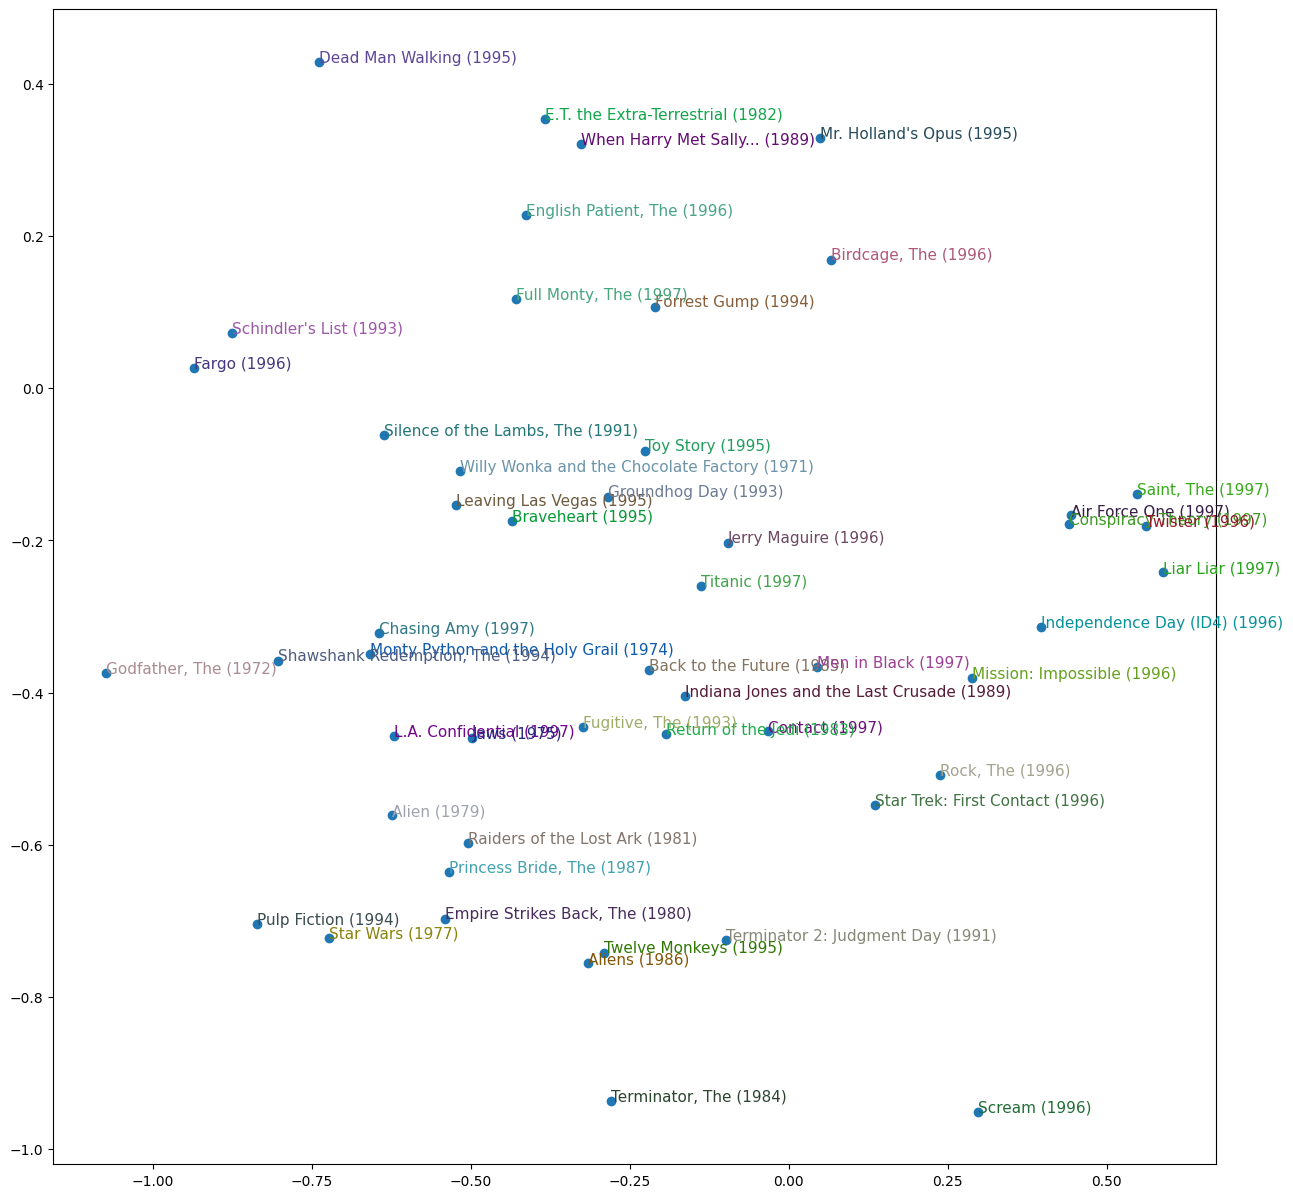

In [50]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

# Define the model architecture
class CustomCollabModel(nn.Module):
    def __init__(self, n_users, n_items, n_factors=50, y_range=(0,5.5)):
        super(CustomCollabModel, self).__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        items = self.item_factors(x[:,1])
        user_b = self.user_bias(x[:,0]).squeeze()
        item_b = self.item_bias(x[:,1]).squeeze()
        return torch.sigmoid((users * items).sum(dim=1) + user_b + item_b).clamp(*self.y_range)

# Define the loss function
def collab_loss(preds, target):
    return F.mse_loss(preds, target.squeeze())

# Assuming n_factors is defined or directly passed
n_users = 1000  # Example value, replace with actual number of users
n_items = 1000  # Example value, replace with actual number of items
n_factors = 50  # You can adjust this value as needed

# Create the model
model = CustomCollabModel(n_users, n_items, n_factors=n_factors)

# Create the Learner object
learn = Learner(dls, model, loss_func=collab_loss, metrics=[mse])


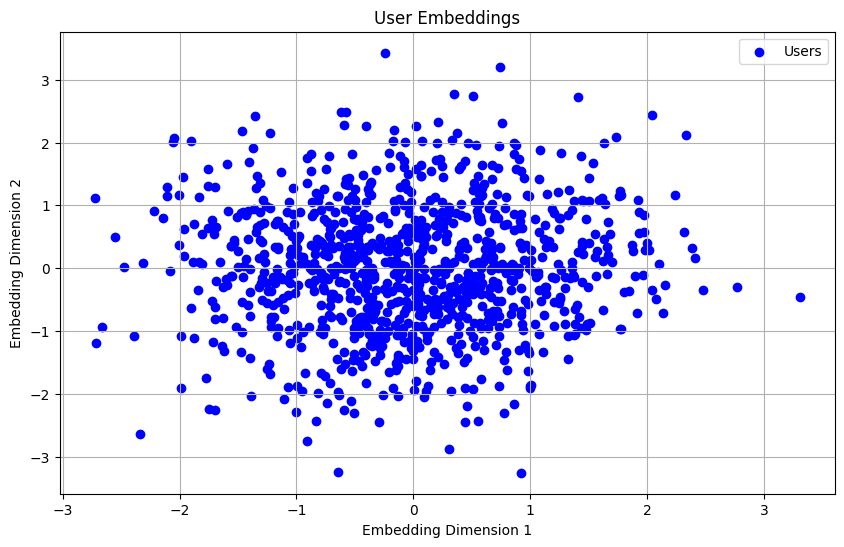

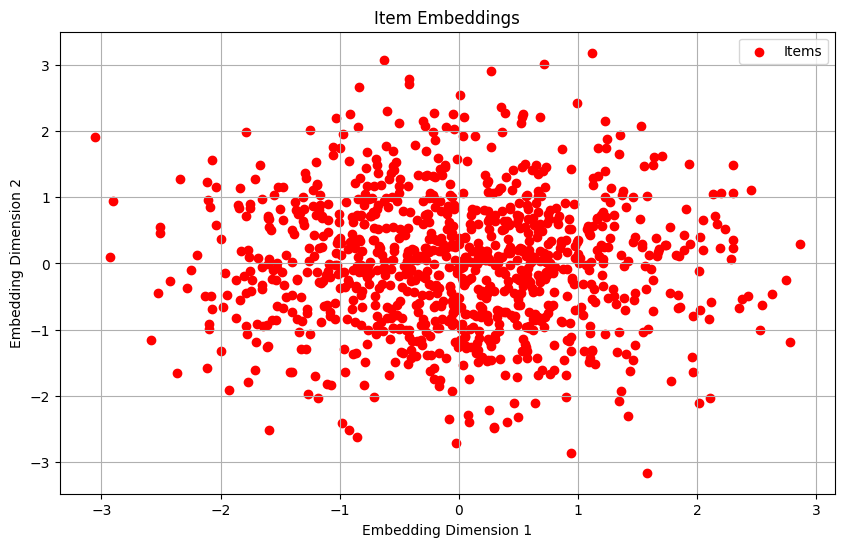

In [52]:
import matplotlib.pyplot as plt

# Extract user and item embeddings
user_embeddings = model.user_factors.weight.data.numpy()
item_embeddings = model.item_factors.weight.data.numpy()

# Visualize user embeddings
plt.figure(figsize=(10, 6))
plt.scatter(user_embeddings[:, 0], user_embeddings[:, 1], label='Users', color='blue')
plt.title('User Embeddings')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

# Visualize item embeddings
plt.figure(figsize=(10, 6))
plt.scatter(item_embeddings[:, 0], item_embeddings[:, 1], label='Items', color='red')
plt.title('Item Embeddings')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.legend()
plt.grid(True)
plt.show()


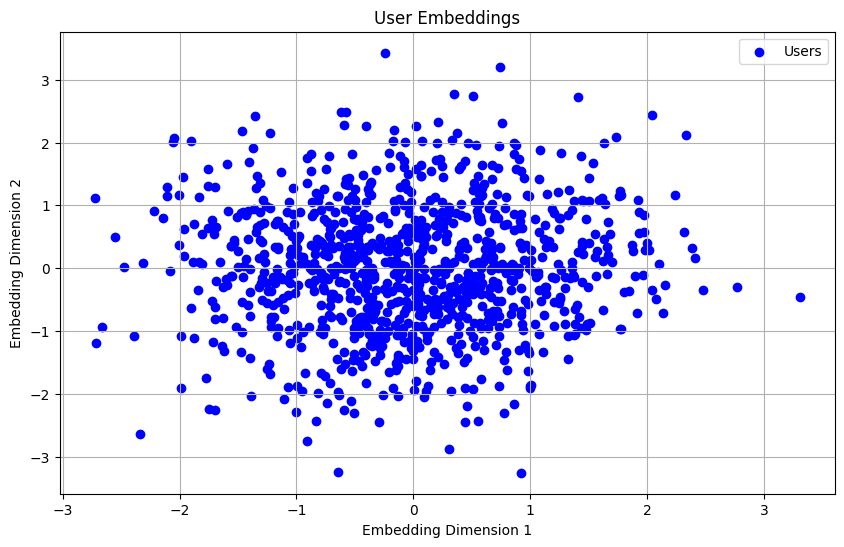

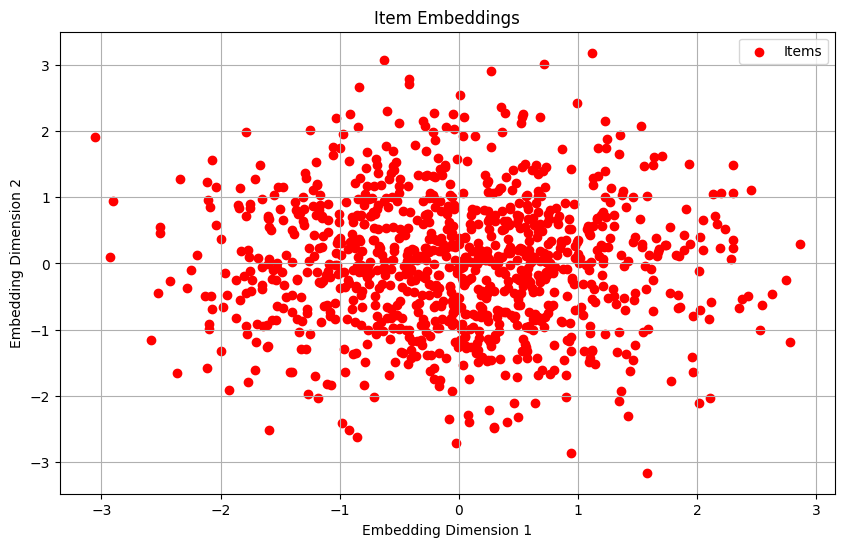

In [53]:
import matplotlib.pyplot as plt

# Extract user and item embeddings
user_embeddings = model.user_factors.weight.data.numpy()
item_embeddings = model.item_factors.weight.data.numpy()

# Visualize user embeddings
plt.figure(figsize=(10, 6))
plt.scatter(user_embeddings[:, 0], user_embeddings[:, 1], label='Users', color='blue')
plt.title('User Embeddings')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

# Visualize item embeddings
plt.figure(figsize=(10, 6))
plt.scatter(item_embeddings[:, 0], item_embeddings[:, 1], label='Items', color='red')
plt.title('Item Embeddings')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.legend()
plt.grid(True)
plt.show()


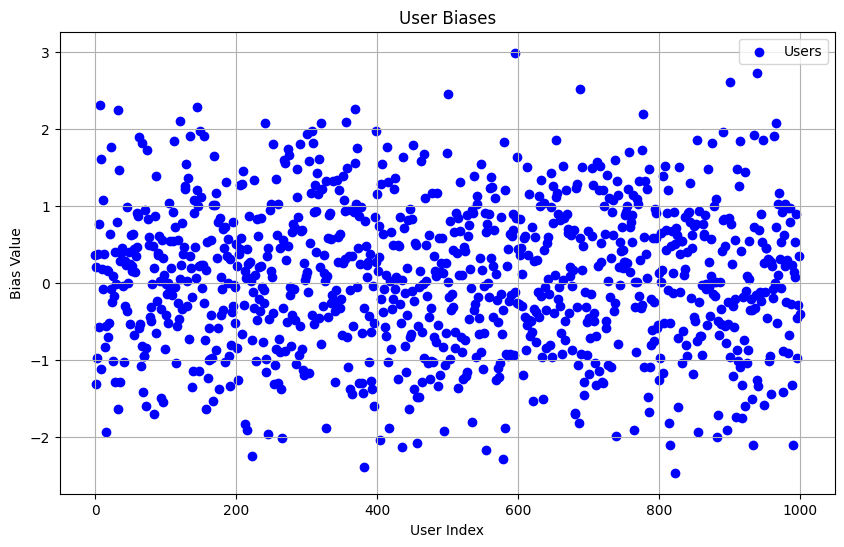

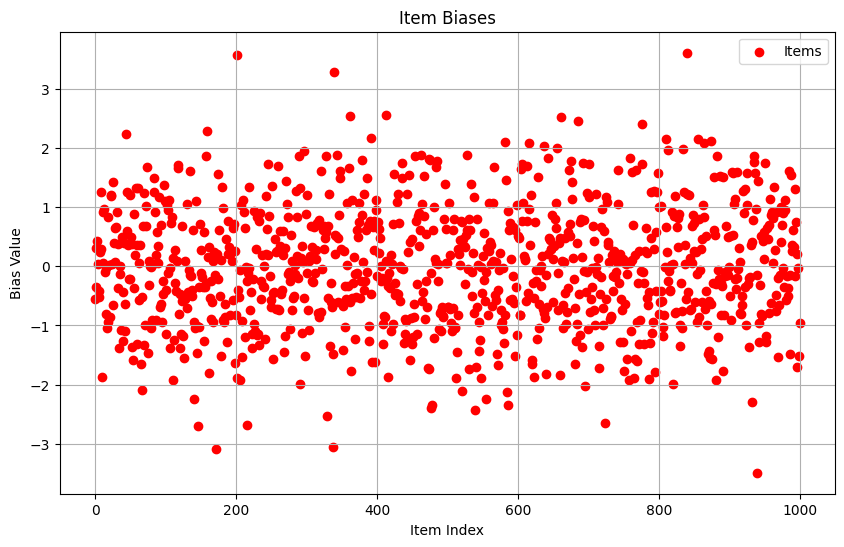

In [54]:
# Extract user and item biases
user_biases = model.user_bias.weight.data.numpy().squeeze()
item_biases = model.item_bias.weight.data.numpy().squeeze()

# Visualize user biases
plt.figure(figsize=(10, 6))
plt.scatter(range(len(user_biases)), user_biases, label='Users', color='blue')
plt.title('User Biases')
plt.xlabel('User Index')
plt.ylabel('Bias Value')
plt.legend()
plt.grid(True)
plt.show()

# Visualize item biases
plt.figure(figsize=(10, 6))
plt.scatter(range(len(item_biases)), item_biases, label='Items', color='red')
plt.title('Item Biases')
plt.xlabel('Item Index')
plt.ylabel('Bias Value')
plt.legend()
plt.grid(True)
plt.show()
